`04_kpi.ipynb`

# KPI(Key Performance Index) - 핵심 성과 지표

## 메트릭 Metric (측정 가능한 모든 수치)
- 방문자수, 클릭수, 매출액, 재고량
- 단순한 측정값

## 지표 Indicator (의미가 부여된 메트릭)
- 전월 대비 방문자 증가율, 클릭 전환률, 매출 성장률
- 비교 기준이 있고, 변화-방향성을 보여줌


In [96]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

warnings.filterwarnings('ignore', category=UserWarning)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
# 실습용 전자상거래 데이터 생성
np.random.seed(42)

# 고객 데이터 생성
customers = pd.DataFrame({
    'customer_id': range(1, 1001),
    'first_purchase_date': pd.date_range('2022-01-01', periods=1000, freq='D'),
    'acquisition_channel': np.random.choice(['organic', 'paid_search', 'social', 'email'], 1000, 
                                          p=[0.4, 0.3, 0.2, 0.1])
})

# 거래 데이터 생성 (더 현실적인 패턴)
transactions = []
for customer_id in range(1, 1001):
    first_date = customers[customers['customer_id'] == customer_id]['first_purchase_date'].iloc[0]
    
    # 고객별로 다른 구매 패턴 시뮬레이션
    purchase_frequency = np.random.exponential(30)  # 평균 30일마다 구매
    num_purchases = np.random.poisson(3) + 1  # 평균 3회 구매
    
    for i in range(num_purchases):
        purchase_date = first_date + timedelta(days=int(i * purchase_frequency))
        if purchase_date <= datetime(2024, 12, 31):
            transactions.append({
                'customer_id': customer_id,
                'purchase_date': purchase_date,
                'order_value': np.random.lognormal(4, 0.8),  # 로그정규분포로 현실적인 주문금액
                'order_id': len(transactions) + 1
            })

df = pd.DataFrame(transactions)
df['purchase_date'] = pd.to_datetime(df['purchase_date'])

print("데이터셋 개요")
print(f"총 고객 수: {len(customers):,}명")
print(f"총 거래 수: {len(df):,}건")
print(f"기간: {df['purchase_date'].min().date()} ~ {df['purchase_date'].max().date()}")
df.columns
df.count()


데이터셋 개요
총 고객 수: 1,000명
총 거래 수: 3,871건
기간: 2022-01-01 ~ 2024-12-28


customer_id      3871
purchase_date    3871
order_value      3871
order_id         3871
dtype: int64

In [97]:
df.head(50)

,customer_id,purchase_date,order_value,order_id
0,1,2022-01-01,16.099022,1
1,1,2022-01-07,52.126636,2
2,1,2022-01-13,105.086917,3
3,1,2022-01-19,60.768899,4
4,1,2022-01-25,78.047045,5
5,1,2022-01-31,46.034085,6
6,1,2022-02-06,134.727679,7
7,1,2022-02-12,51.196306,8
8,2,2022-01-02,17.740889,9
9,2,2022-02-26,81.518230,10


In [98]:
def calculate_rfm(t_df: pd.DataFrame, analysis_date = '2024-12-31'):
    """
    RFM 분석 함수

    Recency: 활성도 측정. 낮을수록 좋음
    Frequency: 충성도 측정. 높을수록 좋음
    Monetary: 가치 측정. 높을수록 좋음
    """
    analysis_date = pd.to_datetime(analysis_date)
    rfm = t_df.groupby('customer_id').agg({
        'purchase_date' : lambda x: (analysis_date - x.max()).days,
        #Frequency
        'order_id' : 'count',
        #Monetary
        'order_value':'sum',
    }).reset_index()
    rfm.columns = ['customer_id','recency','frequency','monetary']
    # RFM  점수 계산
    rfm['r_score'] = pd.qcut(rfm_data['recency'],5,labels = [5,4,3,2,1])
    rfm['f_score'] = pd.qcut(rfm_data['frequency'].rank(method= 'first'), 5, labels = [1,2,3,4,5])
    rfm['m_score'] = pd.qcut(rfm_data['monetary'],5, labels = [1,2,3,4,5])

    rfm['rfm_score'] = rfm['r_score'].astype(str) + rfm['f_score'].astype(str) + rfm['m_score'].astype(str)
    return rfm

def segment_customer(rfm_data: pd.DataFrame):

    """
    RFM 점수를 기반으로 고객을 의미있는 세그먼트로 분류
    - R>=4, F >=4: 최고고객
    - R>=3, F>=3: 충성고객
    - R>=4, F<=2
    """

rfm_data = calculate_rfm(df)
rfm_data.head()



NameError: name 'rfm_data' is not defined

In [ ]:
# segment로 그룹핑해서 분석
segment_analaysis = rfm_segmented.groupby('segment').agg({
    'customer_id': 'count',
    'recency': 'mean',
    'frequency': 'mean',
    'monetary':'mean',
}).round(2)

segment_analysis.columns = ['분류','고객수','지난날평균','회수평균','돈평균']

NameError: name 'rfm_segmented' is not defined

            order_count  MoM_growth_%  YoY_growth_%
year_month                                         
2022-01              49           NaN           NaN
2022-02              57      0.163265           NaN
2022-03              91      0.596491           NaN
2022-04             117      0.285714           NaN
2022-05             120      0.025641           NaN
2022-06             113     -0.058333           NaN
2022-07             106     -0.061947           NaN
2022-08             129      0.216981           NaN
2022-09             117     -0.093023           NaN
2022-10             107     -0.085470           NaN
2022-11             110      0.028037           NaN
2022-12             119      0.081818           NaN
2023-01             128      0.075630    161.224490
2023-02              97     -0.242188     70.175439
2023-03             133      0.371134     46.153846
2023-04             122     -0.082707      4.273504
2023-05             127      0.040984      5.833333
2023-06     

<Axes: xlabel='year_month'>

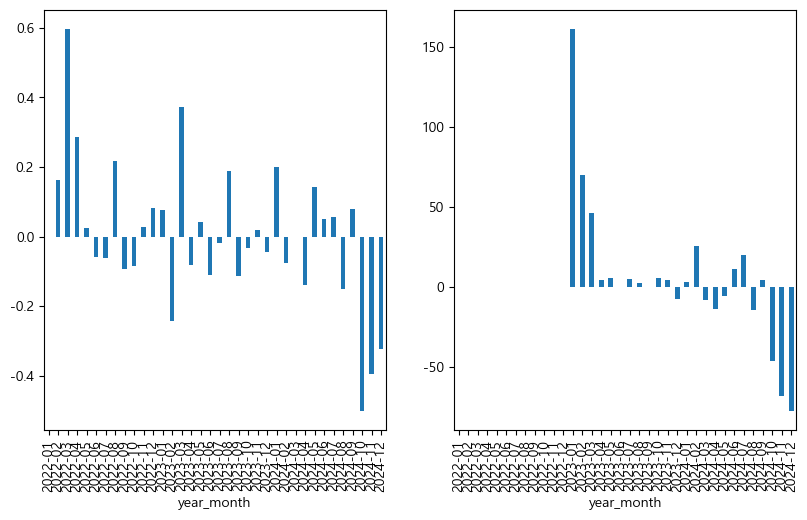

In [ ]:
df['Year_Month'] = df['purchase_date'].dt.to_period('M')
monthly_orders = df.groupby('year_month')['order_id'].count().rename('order_count').to_frame()
monthly_orders['MoM_growth_%'] = monthly_orders['order_count'].pct_change()
monthly_orders['YoY_growth_%'] = monthly_orders['order_count'].pct_change(periods = 12) * 100
print(monthly_orders)
plt.figure(figsize=(15,12))
plt.subplot(2,3,1)
monthly_orders['MoM_growth_%'].plot(kind = 'bar')
plt.subplot(2,3,2)
monthly_orders['YoY_growth_%'].plot(kind = 'bar')

<Axes: xlabel='Year_Month'>

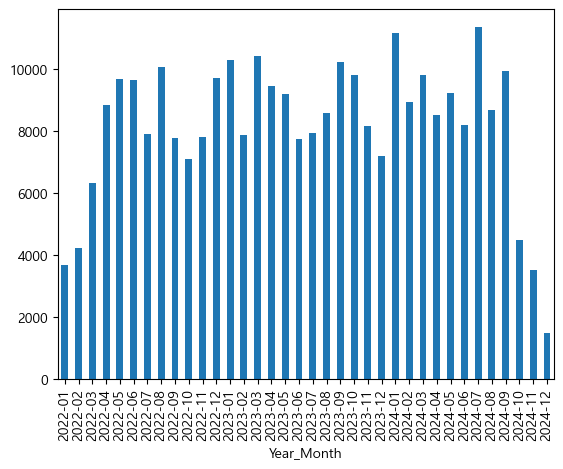

In [ ]:
monthly_revenue = df.groupby('Year_Month')['order_value'].sum()
monthly_revenue.plot(kind = 'bar')


In [ ]:
monthly_revenue = df.groupby(
    df['purchase_date'].dt.to_period('M')
)['order_value'].sum().reset_index()

monthly_revenue.columns  = ['month','revenue']
monthly_revenue['month'] = monthly_revenue['month'].dt.to_timestamp()
monthly_revenue['revenue_lag1'] = monthly_revenue['revenue'].shift(1)
monthly_revenue['mom_growth'] = monthly_revenue['revenue'].shift(1)


,purchase_date,order_value
0,2022-01,3687.604948
1,2022-02,4206.772404
2,2022-03,6322.139871
3,2022-04,8844.628278
4,2022-05,9673.023784
5,2022-06,9638.849098
6,2022-07,7911.223441
7,2022-08,10064.303372
8,2022-09,7772.743095
9,2022-10,7091.942990


In [ ]:
# 컬럼 추가 안 하고 추출 데이터로 그룹핑하기
monthly_revenue = df.groupby( # 각월 별 주문액 총합
    df['purchase_date'].dt.to_period('M')
)['order_value'].sum().reset_index()
monthly_revenue.columns = ['month','revenue']
# month 가 period 타입이기에 dt 로 바꾼다 (일은 강제로 1일)
monthly_revenue['month'] = monthly_revenue['month'].dt.to_timestamp()
# MoM 계산 (전월)
monthly_revenue['revenue_lag1'] = monthly_revenue['revenue'].shift(1)
monthly_revenue['mom_growth'] = (monthly_revenue['revenue'] - monthly_revenue['revenue_lag1']) / monthly_revenue['revenue_lag1'] * 100
# YoY 성장률 (전년 동월)
monthly_revenue['revenue_lag12'] = monthly_revenue['revenue'].shift(12)
monthly_revenue['yoy_growth'] = (monthly_revenue['revenue'] - monthly_revenue['revenue_lag12']) / monthly_revenue['revenue_lag12'] * 100
growth_data = monthly_revenue
growth_data

,month,revenue,revenue_lag1,mom_growth,revenue_lag12,yoy_growth
0,2022-01-01,3687.604948,NaN,NaN,NaN,NaN
1,2022-02-01,4206.772404,3687.604948,14.078717,NaN,NaN
2,2022-03-01,6322.139871,4206.772404,50.284809,NaN,NaN
3,2022-04-01,8844.628278,6322.139871,39.899282,NaN,NaN
4,2022-05-01,9673.023784,8844.628278,9.366086,NaN,NaN
5,2022-06-01,9638.849098,9673.023784,-0.353299,NaN,NaN
6,2022-07-01,7911.223441,9638.849098,-17.923568,NaN,NaN
7,2022-08-01,10064.303372,7911.223441,27.215512,NaN,NaN
8,2022-09-01,7772.743095,10064.303372,-22.769189,NaN,NaN
9,2022-10-01,7091.942990,7772.743095,-8.758814,NaN,NaN


In [ ]:
t_cohort = df.copy()
t_cohort['purchase_period'] = t_cohort

In [ ]:
# 트렌드 분석

# 일별 매출집계

# 이동 평균

# 다양한 기간의 'revenue' 이동평균 (주간, 월간, 분기)

# 트렌드 방향성 분석 + 시각화


In [ ]:
# 최근 12개월 성장률 요약

#전월 대비 성장률 평균
avg_mom = growth_data.tail(12)['mom_growth'].mean()
avg_yoy = growth_data.tail(12)['yoy_growth'].mean()
a1 = axes[0,0]
a1.plot(growth_data['month'],growth_data['revenue'],marker = 'o', linewidth = 2)


NameError: name 'axes' is not defined

In [ ]:
yearly_revenue = df['purchase_date'].dt.to_period('Y')
yearly_revenue['yearly_sales'] = df.groupby('purchase_date')['order_value'].sum()
yearly_revenue.reset_index

C:\Users\mingyu\AppData\Local\Temp\ipykernel_16456\4175706358.py:2: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
  yearly_revenue['yearly_sales'] = df.groupby('purchase_date')['order_value'].sum()
C:\Users\mingyu\AppData\Local\Temp\ipykernel_16456\4175706358.py:2: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
  yearly_revenue['yearly_sales'] = df.groupby('purchase_date')['order_value'].sum()


<bound method Series.reset_index of 0                                                            2022
1                                                            2022
2                                                            2022
3                                                            2022
4                                                            2022
                                      ...                        
3867                                                         2024
3868                                                         2024
3869                                                         2024
3870                                                         2024
yearly_sales    purchase_date
2022-01-01     16.099022
2022-01...
Name: purchase_date, Length: 3872, dtype: object>

In [ ]:
df.count()
df['year_date'] = df['purchase_date'].dt.to_period('Y')
monthly_orders['YoY_growth_%'] = monthly_orders

,customer_id,purchase_date,order_value,order_id,year_month,year_month_,Year_Month,year_date
0,1,2022-01-01,16.099022,1,2022-01,2022,2022-01,2022
1,1,2022-01-07,52.126636,2,2022-01,2022,2022-01,2022
2,1,2022-01-13,105.086917,3,2022-01,2022,2022-01,2022
3,1,2022-01-19,60.768899,4,2022-01,2022,2022-01,2022
4,1,2022-01-25,78.047045,5,2022-01,2022,2022-01,2022
...,...,...,...,...,...,...,...,...
3866,999,2024-12-28,8.301313,3867,2024-12,2024,2024-12,2024
3867,1000,2024-09-26,55.401240,3868,2024-09,2024,2024-09,2024
3868,1000,2024-10-25,75.815793,3869,2024-10,2024,2024-10,2024
3869,1000,2024-11-23,144.276764,3870,2024-11,2024,2024-11,2024


In [ ]:
# 일별 매출 집계
daily_revenue = df.groupby('purchase_date')['order_value'].sum().reset_index()
daily_revenue.columns = ['date', 'revenue']
daily_revenue = daily_revenue.sort_values('date')
daily_revenue

,date,revenue
0,2022-01-01,16.099022
1,2022-01-02,17.740889
2,2022-01-03,151.766243
3,2022-01-04,63.895173
4,2022-01-05,42.936042
...,...,...
1060,2024-12-23,48.623483
1061,2024-12-24,120.585482
1062,2024-12-26,206.660532
1063,2024-12-27,74.943266


In [ ]:
# 이동 평균 계산
daily_revenue['MA_10'] = daily_revenue['revenue'].rolling(window = 10).mean()
daily_revenue

,date,revenue,MA_7,MA_30,MA_90,date_ordinal,MA_10
0,2022-01-01,16.099022,NaN,NaN,NaN,738156,NaN
1,2022-01-02,17.740889,NaN,NaN,NaN,738157,NaN
2,2022-01-03,151.766243,NaN,NaN,NaN,738158,NaN
3,2022-01-04,63.895173,NaN,NaN,NaN,738159,NaN
4,2022-01-05,42.936042,NaN,NaN,NaN,738160,NaN
...,...,...,...,...,...,...,...
1060,2024-12-23,48.623483,90.801196,147.031230,217.692566,739243,91.383842
1061,2024-12-24,120.585482,101.116323,148.366566,217.950140,739244,92.823718
1062,2024-12-26,206.660532,107.844924,145.309130,217.038290,739246,103.306895
1063,2024-12-27,74.943266,97.122699,142.688035,214.569420,739247,103.779765


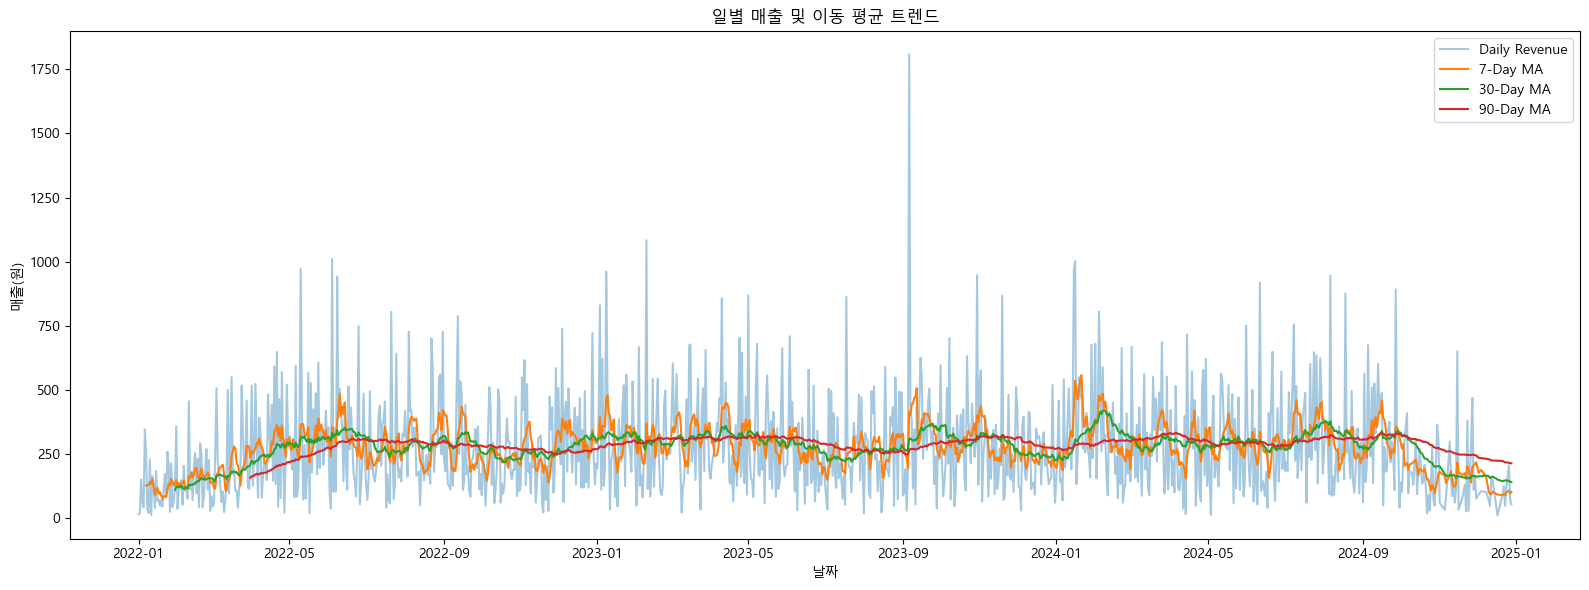

In [ ]:
# 그래프 스타일 지정
plt.figure(figsize=(16, 6))
sns.lineplot(x='date', y='revenue', data=daily_revenue, label='Daily Revenue', alpha=0.4)
sns.lineplot(x='date', y='MA_7', data=daily_revenue, label='7-Day MA')
sns.lineplot(x='date', y='MA_30', data=daily_revenue, label='30-Day MA')
sns.lineplot(x='date', y='MA_90', data=daily_revenue, label='90-Day MA')
plt.title('일별 매출 및 이동 평균 트렌드')
plt.xlabel('날짜')
plt.ylabel('매출(원)')
plt.legend()
plt.tight_layout()
plt.show()

회귀선 기울기 (트렌드 방향성): 0.03
p-value: 0.0987 (0.05보다 작으면 통계적으로 유의미한 추세)


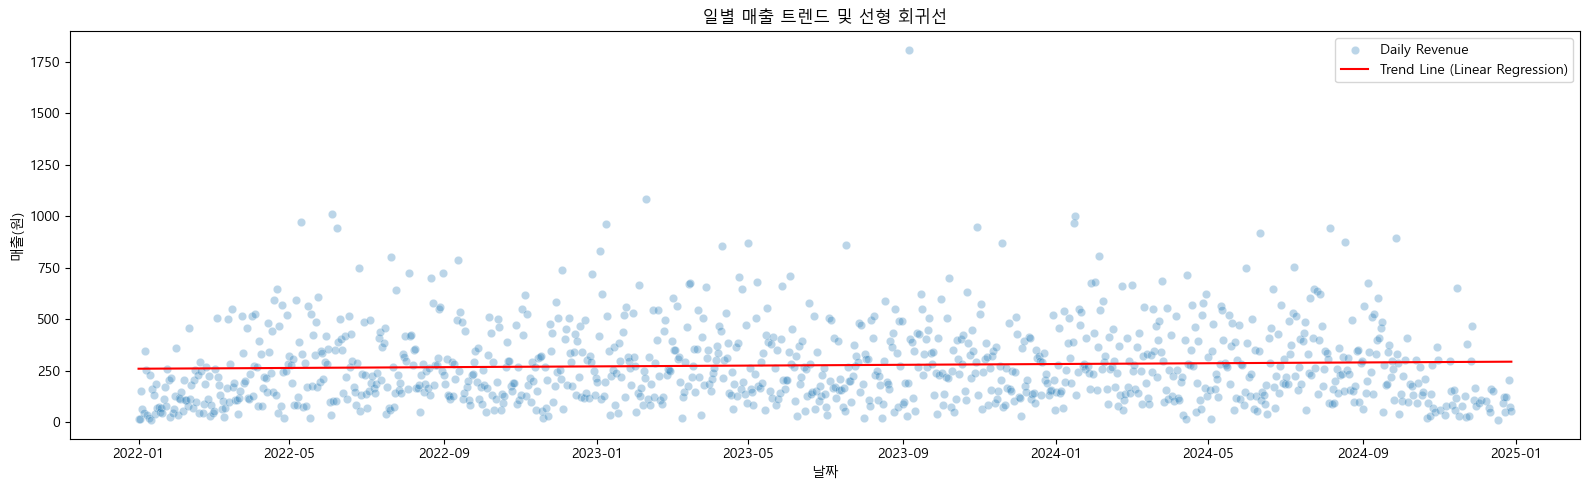

In [ ]:
# 회귀분석을 위한 숫자형 날짜 변환
daily_revenue['date_ordinal'] = daily_revenue['date'].map(datetime.toordinal)

# 선형 회귀 분석
slope, intercept, r_value, p_value, std_err = stats.linregress(
    daily_revenue['date_ordinal'], daily_revenue['revenue']
)

print(f"회귀선 기울기 (트렌드 방향성): {slope:.2f}")
print(f"p-value: {p_value:.4f} (0.05보다 작으면 통계적으로 유의미한 추세)")

# 회귀선 시각화
plt.figure(figsize=(16, 5))
sns.scatterplot(x='date', y='revenue', data=daily_revenue, alpha=0.3, label='Daily Revenue')
plt.plot(
    daily_revenue['date'],
    intercept + slope * daily_revenue['date_ordinal'],
    color='red',
    label='Trend Line (Linear Regression)'
)
plt.title('일별 매출 트렌드 및 선형 회귀선')
plt.xlabel('날짜')
plt.ylabel('매출(원)')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd

# 마케팅 지출 및 채널 확장성 점수 (1~100)
marketing_data = pd.DataFrame({
    'channel': ['Google Ads', 'Facebook', 'Instagram', 'Email', 'Organic', 'Referral'],
    'marketing_spend': [50000, 40000, 25000, 10000, 0, 3000],
    'scalability_score': [90, 85, 75, 60, 95, 70]
})

# 고객 획득 수 / LTV / 획득 시간
acquisition_data = pd.DataFrame({
    'channel': ['Google Ads', 'Facebook', 'Instagram', 'Email', 'Organic', 'Referral'],
    'customers_acquired': [200, 180, 120, 80, 300, 60],
    'avg_ltv': [1200, 1000, 800, 700, 950, 1000],
    'avg_acquisition_days': [5, 7, 10, 20, 40, 25]
})

acquisition_data

,channel,customers_acquired,avg_ltv,avg_acquisition_days
0,Google Ads,200,1200,5
1,Facebook,180,1000,7
2,Instagram,120,800,10
3,Email,80,700,20
4,Organic,300,950,40
5,Referral,60,1000,25


In [ ]:
perf_df = pd.merge(marketing_data,acquisition_data, on = 'channel')


In [ ]:
# CAC 계산(Customer Acquistion Cost - 고객 획득 비용)

perf_df = pd.merge(marketing_data,acquisition_data, on = 'channel')

# 1. 'avg_ltv' 고객 퀄리티 가중치(LTV)
perf_df['quality_weight'] = perf_df['avg_ltv'] / perf_df['avg_ltv'].mean() 

# 2. 'avg_acq_days' 시간가치 가중치 (획득 속도)
perf_df['time_weight'] = perf_df['avg_acquisition_days'].max() / perf_df['avg_acquisition_days']

# 3. 'scalability' 확장성 가중치
perf_df['scalability_weight'] = perf_df['scalability_score'] / 100

# 종합 가중치 (qw - 50 %, tw - 30%, sw - 20%)
perf_df['composite_weight'] = (
    perf_df['quality_weight'] * 0.5 +
    perf_df['time_weight'] * 0.3 +
    perf_df['scalability_weight'] * 0.2
)
perf_df


,channel,marketing_spend,scalability_score,customers_acquired,avg_ltv,avg_acquisition_days,quality_weight,time_weight,scalability_weight,composite_weight
0,Google Ads,50000,90,200,1200,5,1.274336,8.000000,0.90,3.217168
1,Facebook,40000,85,180,1000,7,1.061947,5.714286,0.85,2.415259
2,Instagram,25000,75,120,800,10,0.849558,4.000000,0.75,1.774779
3,Email,10000,60,80,700,20,0.743363,2.000000,0.60,1.091681
4,Organic,0,95,300,950,40,1.008850,1.000000,0.95,0.994425
5,Referral,3000,70,60,1000,25,1.061947,1.600000,0.70,1.150973


In [100]:
# 일반 CAC 계산 -> 각 채널별 1인 데려오는데 쓴돈
perf_df['simple_cac'] = perf_df['marketing_spend']/perf_df['customers_acquired']

# 가중치 반영한 CAC 계산
perf_df['weighted_cac'] = perf_df['simple_cac'] / perf_df['composite_weight']

perf_df[['channel','simple_cac','weighted_cac','composite_weight']]


,channel,simple_cac,weighted_cac,composite_weight
0,Google Ads,250.000000,77.708093,3.217168
1,Facebook,222.222222,92.007610,2.415259
2,Instagram,208.333333,117.385523,1.774779
3,Email,125.000000,114.502270,1.091681
4,Organic,0.000000,0.000000,0.994425
5,Referral,50.000000,43.441489,1.150973


KeyError: ''

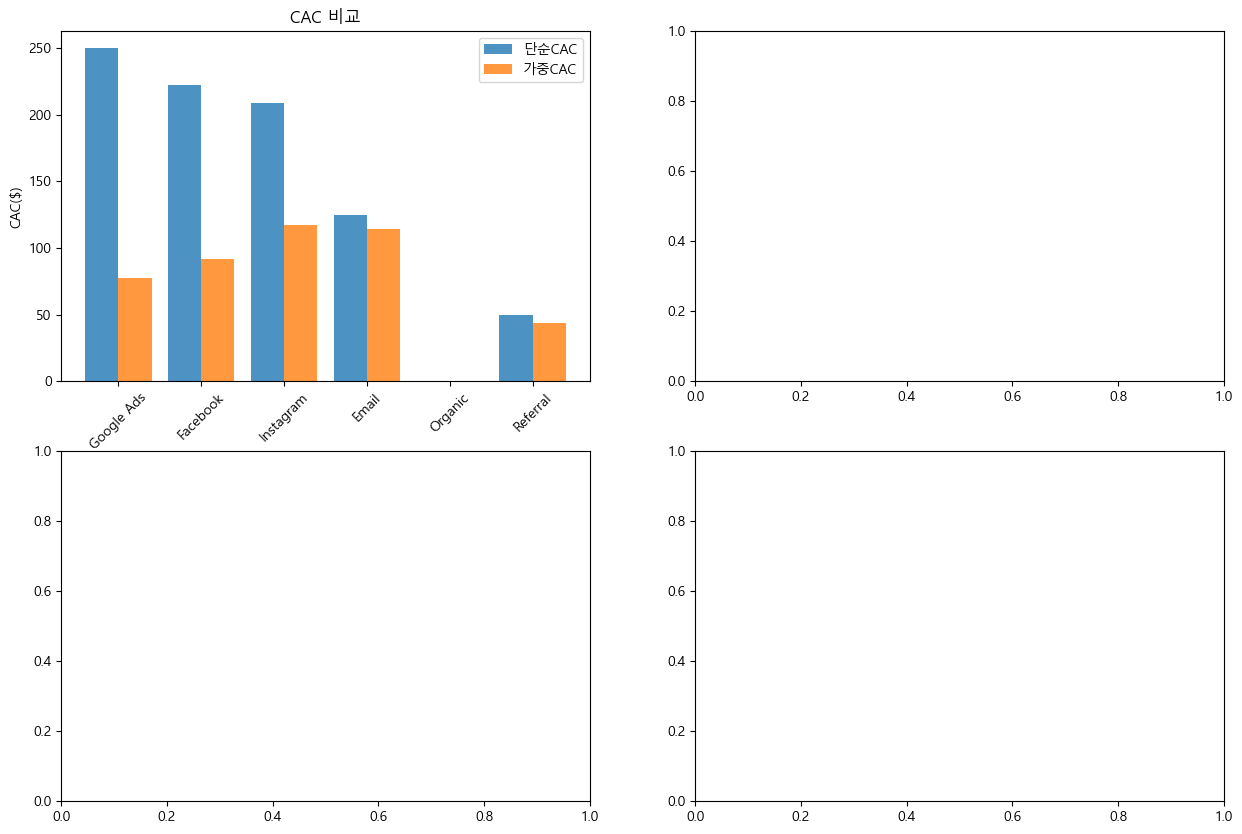

In [101]:
fig, axes = plt.subplots(2,2,figsize = (15, 10))
x_pos = np.arange(len(perf_df))
a1, a2, a3, a4 = axes[0,0], axes[0,1], axes[1,0], axes[1,1]

# 단순 CAC, 가중 CAC 비교
a1.bar(x_pos - 0.2, perf_df['simple_cac'], 0.4, label = '단순CAC',alpha = 0.8)
a1.bar(x_pos + 0.2, perf_df['weighted_cac'], 0.4, label = '가중CAC',alpha = 0.8)
a1.set_title('CAC 비교')
a1.set_xticks(x_pos)
a1.set_xticklabels(perf_df['channel'],rotation = 45)
a1.set_ylabel('CAC($)')
a1.legend()

# ROI 분석 (LTV/CAC 비율)
perf_df['roi'] = perf_df['avg_ltv'] / perf_df['weighted_cac']
perf_df['weighted_roi'] =perf_df['avg_ltv'] / perf_df['']
a2.bar(x_pos, perf_df['roi'], color='green', alpha=0.7)
a2.set_title('ROI 분석 (LTV / 가중CAC)')
a2.set_xticks(x_pos)
a2.set_xticklabels(perf_df['channel'], rotation=45)
a2.set_ylabel('ROI (배)')

# 산점도 
a3.scatter(perf_df['simple_roi'],perf_df['weighted_roi'], s = 50 , alpha = 0.7)
for idx, channel in enumerate(perf_df['channel']):
    a3.annotate(channel, (perf_df['simple_roi'].iloc[idx]+0.3, perf_df['weighted_roi'].iloc[idx]+0.3))

a3.plot([0,20],[0, 20], 'r--', alpha = 0.5)


# 최적 마케팅 믹스 (파이 그래프)
"""
ROI와 Scalability를 함께 고려할 예정
1. 효율성 지표(Efficieny Score)라는 항목으로 ROI, 확장성을 동시에 계산 -> 성과도 좋고 확장여지도 크다!!
2. 예산 배분 기준 -> 효율성 지표에 따라 

"""
budget_opt = perf_df.copy()
budget_opt['eff_score'] = budget_opt['weighted_roi'] * budget_opt['scalability_score'] / 100

budget_opt['recommend_pct'] = budget_opt['eff_score'] / budget_opt['eff_score'].sum()* 100
a4.pie(budget_opt['recommend_pct'], labels = budget_opt['channel'], autopct = '%1.1f%%')

# 추천 마케팅 비중 = 각 채널이 전체 ROI에서 차지하는 비율로 할당
# perf_df['roi_share'] = perf_df['roi'] / perf_df['roi'].sum()
# a3.pie(perf_df['roi_share'], labels=perf_df['channel'], autopct='%1.1f%%', startangle=140)
# a3.set_title('추천 마케팅 믹스 (ROI 기준)')

plt.tight_layout()
plt.show()

In [ ]:
for idx, value in enumerate(clv_values):
    plt.text(idx,value+ 10, f'${value:.0f}',ha='center')
plt.tight_layout()
plt.show()


In [102]:

import pandas as pd

# 마케팅 지출 및 채널 확장성 점수 (1~100)
marketing_data = pd.DataFrame({
    'channel': ['Google Ads', 'Facebook', 'Instagram', 'Email', 'Organic', 'Referral'],
    'marketing_spend': [50000, 40000, 25000, 10000, 0, 3000],
    'scalability_score': [90, 85, 75, 60, 95, 70]
})

# 고객 획득 수 / LTV / 획득 시간
acquisition_data = pd.DataFrame({
    'channel': ['Google Ads', 'Facebook', 'Instagram', 'Email', 'Organic', 'Referral'],
    'customers_acquired': [200, 180, 120, 80, 300, 60],
    'avg_ltv': [1200, 1000, 800, 700, 950, 1000],
    'avg_acquisition_days': [5, 7, 10, 20, 40, 25]
})

acquisition_data

,channel,customers_acquired,avg_ltv,avg_acquisition_days
0,Google Ads,200,1200,5
1,Facebook,180,1000,7
2,Instagram,120,800,10
3,Email,80,700,20
4,Organic,300,950,40
5,Referral,60,1000,25


In [103]:
acquisition_data.merge(marketing_data, on = 'channel')

,channel,customers_acquired,avg_ltv,avg_acquisition_days,marketing_spend,scalability_score
0,Google Ads,200,1200,5,50000,90
1,Facebook,180,1000,7,40000,85
2,Instagram,120,800,10,25000,75
3,Email,80,700,20,10000,60
4,Organic,300,950,40,0,95
5,Referral,60,1000,25,3000,70


In [104]:
# 문제 1: 채널별 고객 획득 비용(CAC) 및 생애 가치(LTV) 분석
# 목표: 마케팅 채널의 진정한 ROI를 평가하기 위해 CAC와 LTV를 계산하고 최적 투자 전략을 제안하세요.
# 1. 데이터 로드 및 전처리
# 2. 채널별 CAC 계산
#     - 2024년 데이터만 사용
#     - 각 채널별 총 마케팅 비용 집계
#     - 각 채널별 신규 고객 수 집계 (2024년 첫 거래 기준)
#     - CAC = 총 마케팅 비용 / 신규 고객 수
#     - organic과 referral 채널은 CAC = 0으로 처리
# 3. 고객별 LTV 계산
# 4. 채널별 LTV 및 ROI 분석
#     - 채널별 평균 LTV 계산
#     - ROI = LTV / CAC 계산 (organic, referral은 무한대 처리)
#     - payback period = CAC / (월평균 구매금액) 계산
# 5. 시각화 및 전략 제안 (15분)
#     - CAC vs LTV 산점도 차트
#     - 채널별 ROI 막대 차트
#     - 마케팅 예산 재배분 제안 (현재 vs 최적 배분)
# 1. 고객별 LTV 계산 (누적 구매금액 기준)
ltv_by_customer = df_tx.groupby('customer_id')['order_value'].sum().rename('ltv')

# 2. 고객별 acquisition_channel 추출 (최초 거래 기준)
first_tx = df_tx.sort_values('transaction_date').drop_duplicates('customer_id', keep='first')
customer_channels = first_tx.set_index('customer_id')['acquisition_channel']

# 3. LTV + acquisition_channel 합치기
ltv_df = pd.concat([ltv_by_customer, customer_channels], axis=1)

# 4. 채널별 평균 LTV 계산
ltv_by_channel = ltv_df.groupby('acquisition_channel')['ltv'].mean().rename("avg_ltv")

# 결과 확인
print(ltv_by_channel)


NameError: name 'df_tx' is not defined